In [3]:
# We are going to generate Synthetic data based on real world sensitivity and Specificity 
# ranges for Pneumonia
# Sensitivity - True Positives (X%) means X% of patients with this symptoms have Pneumonia, means
# higher Sensitivity higher chances of having diesease
# Specificity - False Negatives (X%) means X% of non pneumonia patients doesn't have presence of this specific symptom


# firstly we import necessary libraries
import numpy as np
import pandas as pd
import random

![Alt Text](Images/SS.png)

In [5]:
num_samples = 3000

# symptoms and their sensitivity/specificity ranges
symptoms = {
    "fever": (0.47, 0.66, 0.42, 0.67),
    "chills": (0.69, 0.80, 0.53, 0.67),
    "cough": (0.10, 1.00, 0.00, 0.94),
    "sputum": (0.12, 1.00, 0.21, 0.95),
    "dyspnea": (0.46, 0.85, 0.22, 0.67),
    "chest_pain": (0.16, 0.75, 0.41, 0.82),
    "wheezing": (0.19, 0.70, 0.47, 0.83),
    "diarrhea": (0.11, 0.19, 0.93, 0.94)
}

In [6]:
# Generating data based on above ranges
#0th index - Sensitivity lower bound
#1st index - Sensitivity upper bound
#2nd index - Specificity lower bound
#3rd index - Specificity upper bound

data = []

for _ in range(num_samples):
    has_pneumonia = np.random.choice([0,1])

    patient = {"pneumonia" : has_pneumonia}

    for symptom, (sens_low, sens_high, spec_low, spec_high) in symptoms.items():
        #if condition = 1 means pneumonia is present thus gonna use sensitivity
        if has_pneumonia:
            prob = random.uniform(sens_low, sens_high)
        else:
            prob = 1 - random.uniform(spec_low, spec_high)

        patient[symptom] = np.random.choice([0, 1], p=[1-prob, prob])
    data.append(patient)

# Converting into data-frame
df = pd.DataFrame(data)

df.to_csv("pneumonia_symptoms_data.csv", index=False)

print(df.head())

   pneumonia  fever  chills  cough  sputum  dyspnea  chest_pain  wheezing  \
0          1      0       1      0       0        0           1         1   
1          1      0       1      1       1        1           0         0   
2          0      1       0      0       1        0           0         0   
3          1      0       1      1       0        1           1         1   
4          0      0       0      1       0        0           1         0   

   diarrhea  
0         0  
1         0  
2         0  
3         0  
4         0  


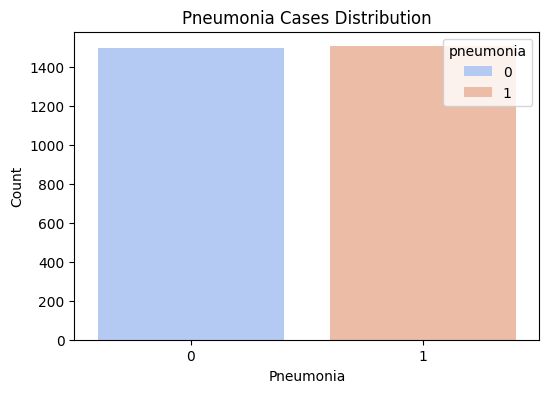

In [7]:
# Lets visulaise the dataset and see if we can increase the quality of data by removing
# some less important symptomps

import matplotlib.pyplot as plt
import seaborn as sns

# CountPlot - Distribution of pneumonia vs non-pneumonia

plt.figure(figsize = (6,4))
sns.countplot(data = df, x = "pneumonia",hue = "pneumonia", palette="coolwarm")
plt.title("Pneumonia Cases Distribution")
plt.xlabel("Pneumonia")
plt.ylabel("Count")
plt.show()

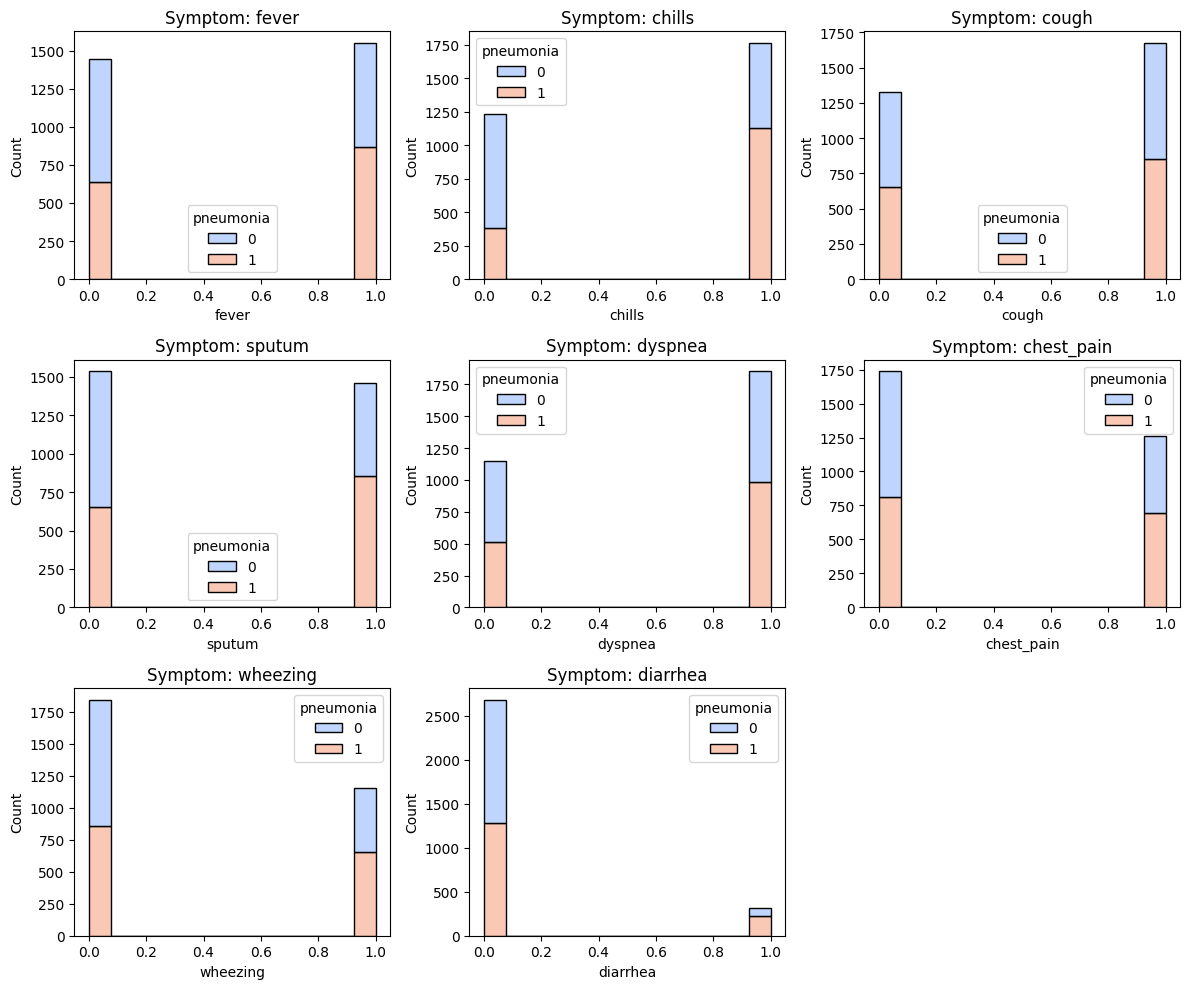

In [8]:
plt.figure(figsize = (12,10))

for i, symptom in enumerate(df.columns[1:]):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=symptom, hue = "pneumonia", multiple = "stack", palette = "coolwarm")
    plt.title(f"Symptom: {symptom}")

plt.tight_layout()
plt.show()

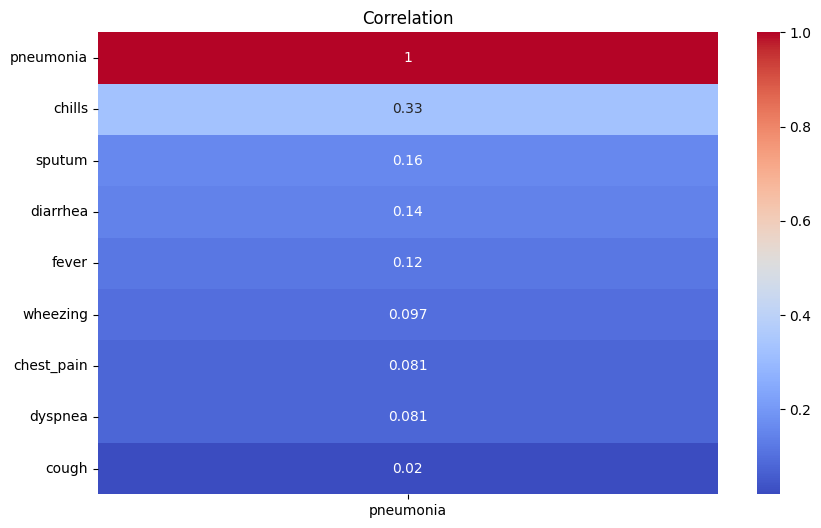

In [9]:
# Trying to find important features by doing correlation analysis

df = pd.read_csv("pneumonia_symptoms_data.csv")

correlation = df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(correlation[['pneumonia']].sort_values(by='pneumonia', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation")
plt.show()

Model accuracy with many features  0.62


C:\Users\Hi\AppData\Local\Temp\ipykernel_20904\2129837702.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Importance', y = 'Feature', data= importances, palette="viridis")


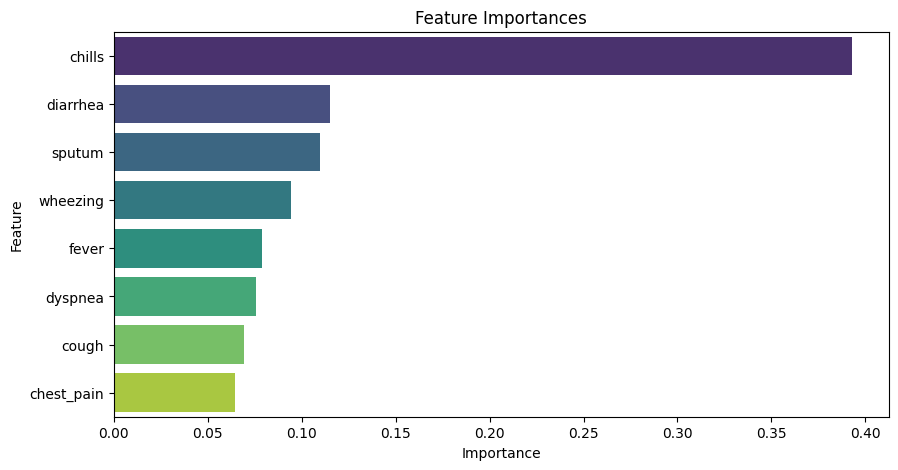

In [10]:
#  Now let us see with the present dataset we train an Random forest model and check for feature importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Splitting data into features (X) and target (y)
X = df.drop(columns=['pneumonia'])
y = df['pneumonia']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy with many features {accuracy: .2f}")

# Features Importance
importances = pd.DataFrame({'Feature' : X.columns, 'Importance': model.feature_importances_})
importances = importances.sort_values(by = 'Importance', ascending = False)

# Feature Importance Plot
plt.figure(figsize=(10,5))
sns.barplot(x = 'Importance', y = 'Feature', data= importances, palette="viridis")

plt.title("Feature Importances")
plt.show()

In [11]:
# We can see from correlation plot and Feature importances from Random Forest that important 
# features are chills, sputum, and fever so let us remove other symptoms and train model
# again and see if we can increase the accuracy

important_features = ["pneumonia", "chills", "sputum", "fever"]
df_reduced = df[important_features]

# New dataset
df_reduced.to_csv("reduced_dataset.csv", index = False)


In [12]:
dc = pd.read_csv("reduced_dataset.csv")

X = dc.drop(columns=["pneumonia"])
y = dc["pneumonia"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy after feature reduction : {accuracy:.2f}")



Accuracy after feature reduction : 0.63


In [13]:
# #  As we can see with reduced features it is giving nearly same accuracy we are going to 
# # use reduced dataset with reduced featues to predict for pneumoonia

# # Now saving the model and predicting based on it
import joblib
joblib.dump(model, "pneumonia_model.joblib")

['pneumonia_model.joblib']

In [54]:
import pickle
import numpy as np
import pandas as pd
import sklearn

def load_model(filepath):
  """Loads a pickled model."""
  with open(filepath, 'rb') as file:
    model = joblib.load(file)
  return model

model = load_model('/PneumoniaDetection/pneumonia_model.joblib')

In [64]:
input_data = np.array([[0,1,1]])
prediction = model.predict(input_data)
print(prediction)

[0]


C:\Users\Hi\anaconda3\envs\pneumonia-detection\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
